# A science walk-through combining CIAO and astropy in a single workflow
## Science topic: What is the hottest Cool Star?
In recent years, we have made it much easier to control your CIAO analysis from Python. While it is still possible to call CIAO tools on the command line (either by hand or by means of a script, e.g. in bash or Python), that is no longer the only viable option for scripting. In particular, the `ciao_contrib` package (which is part of the default CIAO install), includes code to call CIAO tasks nicely from Python. In CIAO 4.13, we then made it much easier to install other Python packages into the same Python environment that is set up with CIAO. That really simplifies many workflows, because it is now possible to seamlessly combine CIAO analysis with other Python packages in one script or one Jupyter notebook. In particular, we can use CIAO tools and [astropy](https:///www.astropy.org) or astropy affiliated packages together.

This notebook walks through one full science example from downloading the data from the Chandra archive to data reduction and making publication quality figures. In fact, the analysis shown here and the figures made here can all be discussed in detail in [Günther et al. (2021)](https://adswww.harvard.edu).

This notebook is a little different from typical CIAO threads in two ways:

- It makes use of Python packages not distributed with CIAO (We will explain how to install them when needed).
- Instead of explaining one particular topic in depth (e.g. how to reduce HRC imaging data in different situations), it goes through all the steps of a full science analysis, but with limited explanations.

In [207]:
import sys
from glob import glob

import numpy as np
from astropy.table import QTable, Table, hstack
from astropy.io import fits, ascii
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord, Distance
from astropy.time import Time
from astroquery.simbad import Simbad
from astroquery import vizier
import astropy.units as u
from astropy.visualization.wcsaxes import SphericalCircle
from astropy.stats import poisson_conf_interval

from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator

from ciao_contrib import runtool as rt
from ciao_contrib.cda.data import download_chandra_obsids

%matplotlib inline

In [2]:
obsids = [18930, 18931, 18932, 18933]

### Download the data
Almost all CIAO tasks are called from the `ciao_contrib.runtool` module. The one exception to this is downloaded data, which is done from the `ciao_contrib.cda.data` module.

Note that this can take a while and the default configuration does not write anything to the screen in between.
Your script is not "hanging", it's downloading!

In [2]:
rval = download_chandra_obsids(obsids)
if not np.all(rval):
    print('The following ObsIDs do not exisit: ', np.array(obsids)[rval])

###  `chandra_repro`
The data from the archive may or may not have gone through recent reprocessing. Just in case, it's always best to run the `chandra_repro` script on it again. Note that this step can take a few minutes, just like the downloading. If you already downloaded and reprocessed the data and are just re-runnng the notebook to change something further down, you cna save the time and just skip this step.

In [5]:
# process all dirs with default settings
rt.chandra_repro(indir= "*", outdir="")


Running chandra_repro
version: 01 December 2020


Input is not a directory: 'WhatIsTheHottstCoolStar.ipynb'. Skipping it


Processing input directory '/Users/hamogu/projects/Chandraprojects/HotestCoolStar/18930'

No boresight correction update to asol file is needed.

Running hrc_build_badpix to create new bad pixel file...

Running hrc_process_events to reprocess the evt1.fits file...
Output from hrc_process_events:
# hrc_process_events (CIAO 4.13): The following error occurred 38 times:
	dsHPEEVENTSEQERR -- WARNING: Out of sequence events discovered in /Users/hamogu/projects/Chandraprojects/HotestCoolStar/18930/secondary/hrcf18930_000N002_evt1.fits.
Filtering the evt1.fits file on grade and status...
Applying the good time intervals from the flt1.fits file...

Running hrc_dtfstats to recompute the average dead time corrections...
The new level=2 event file is: /Users/hamogu/projects/Chandraprojects/HotestCoolStar/18930/repro/hrcf18930_repro_evt2.fits

Updating the event file header 

## Can we imporve the accuracy of the astrometry by cross-matching with other catalogs?
That only works if there are multiple other sources in the FOV that are bright and unambiguously matched to some other catalog. To get an idea, I first looked interactively in DS9 and loaded the SIMBAD catalog. OBsIDS 18932 and 18933 have one SIMBAD source, that's visible in the HRC data each both of which seem to match well, but let's get a number on that.



In [18]:
for obsid in obsids:
    print('Working on ', obsid)
    fileevt2 = glob(f'{obsid}/repro/*evt2*')[0]
    asol = glob(f'{obsid}/repro/pcad*asol*')[0]
    bpix = glob(f'{obsid}/repro/*bpix*')[0]
    rt.ardlib.AXAF_HRC_I_BADPIX_FILE = bpix
    rt.ardlib.write_params()
    # Choice of binning cuts off the edges of the FOV for some observations
    # but (i) in those regions the PSF is very large and not useful for
    # us to improve astronmetry anyway and (ii) there are no bright sources
    # (as seen interactively in ds9).
    # On the other hand, wavedect takes much longer with bigger files
    rt.dmcopy(infile=f"{fileevt2}[bin x=8000:24000:4,y=8000:24000:4]", 
              outfile=f'{obsid}/image.fits', clobber=True, option='image')
    rt.mkpsfmap(infile=f'{obsid}/image.fits', outfile=f'{obsid}/psfmap.fits',
                energy=1.5, ecf=0.393, clobber=True)
    rt.wavdetect.punlearn()
    rt.wavdetect(infile=f'{obsid}/image.fits', psffile=f'{obsid}/psfmap.fits',
                 outfile=f'{obsid}/src.fits', scellfile=f'{obsid}/scell.fits', imagefile=f'{obsid}/imgfile.fits',
                 defnbkgfile=f'{obsid}/nbgd.fits', regfile=f'{obsid}/src.reg', 
                 clobber=True,  # just in case we run the same notebook again, we probably want to overwrite
                 scales='2 4 8 16', # We only care for point sources or small sources.
                                 # Large, resolved sources won't help us with astrometry
                 sigthresh=1e-6  # We want bright, highly significant sources
                 )


Working on  18930
Working on  18931
Working on  18932
Working on  18933


In [108]:
myVizier = vizier.Vizier(row_limit=5000)

In [109]:
for obsid in obsids:
    print('Working on ', obsid)
    fileevt2 = glob(f'{obsid}/repro/*evt2*')[0]
    twomass = myVizier.query_region(fits.getval(fileevt2, 'OBJECT', ext=('EVENTS', 1)), 
                                  radius=.3*u.deg, catalog='II/246/out')
    twomass[0].rename_column('RAJ2000', 'RA')
    twomass[0].rename_column('DEJ2000', 'DEC')
    twomass[0].write(f'{obsid}/2mass.csv', format='ascii.commented_header', overwrite=True)
    print(len(twomass[0]))
    try:
        rt.wcs_match(infile=f'{obsid}/src.fits', refsrcfile=f'{obsid}/2mass.csv', 
             outfile=f'{obsid}/xfm.fits', wcsfile=fileevt2,
             radius=2, residlim=1, verbose=1, clobber=True)
        print(rt.wcs_match.get_runtime_details()['output'])
    except OSError as e:
        print(e)
        

Working on  18930
1956
An error occurred while running 'wcs_match':
  # wcs_match (CIAO 4.13): WARNING: Ref src x_err or ra_err cols not found.  Assuming x_err = 1.
  # wcs_match (CIAO 4.13): WARNING: Ref src y_err or dec_err cols not found.  Assuming y_err = 1.
  # wcs_match (CIAO 4.13): ERROR: Cannot find at least 3 source matches between reference and duplicate source files (method=rst).
   input (dup) src file : 18930/src.fits
   input ref src file   : 18930/2mass.csv
   input wcsfile        : 18930/repro/hrcf18930_repro_evt2.fits
   debug level          : 1
  
  0 common sources found between: 
  18930/2mass.csv
  18930/src.fits
  After deleting poor matches, 0 sources remain
Working on  18931
385
An error occurred while running 'wcs_match':
  # wcs_match (CIAO 4.13): WARNING: Ref src x_err or ra_err cols not found.  Assuming x_err = 1.
  # wcs_match (CIAO 4.13): WARNING: Ref src y_err or dec_err cols not found.  Assuming y_err = 1.
  # wcs_match (CIAO 4.13): ERROR: Cannot find at

In [114]:
print(rt.wcs_match.get_runtime_details()['output'])

# wcs_match (CIAO 4.13): WARNING: Ref src x_err or ra_err cols not found.  Assuming x_err = 1.
# wcs_match (CIAO 4.13): WARNING: Ref src y_err or dec_err cols not found.  Assuming y_err = 1.
 input (dup) src file : 18933/src.fits
 input ref src file   : 18933/2mass.csv
 input wcsfile        : 18933/repro/hrcf18933_repro_evt2.fits
 debug level          : 1

3 common sources found between: 
18933/2mass.csv
18933/src.fits
After deleting poor matches, 3 sources remain

Source Residuals
----------------
 Src  Ref#  Dup#    Ref RA      Ref Dec.    Prior Resid           Transfm Resid         Resid  Incl
 Indx               (deg.)      (deg.)      RSS (x,y)             RSS (x,y)             Ratio
                                            (arcsec)              (arcsec)
   0  137     5     45.69832   -23.74512    1.77 ( 1.07, 1.41)    0.00 ( 0.00, 0.00)    0.00    Y
   1  192     8     45.72177   -23.65152    1.30 ( 1.13,-0.65)    0.00 (-0.00,-0.00)    0.00    Y
   2  222     3     45.55491   

### Obslog table

Next, we parse the header information in the evt2 files in each obsid to construct a table for the publication. Although the initial table is already pretty good, we do some extra steps to fix e.g. the capitalization of the column names, to convert target ASCII names into proper LaTeX etc. to make the table generally more pleasing. In this case, writing this code takes probably about as long as writing this table by hand, but note that we can re-use the code in this cell for all future Chandra projects since the format of the header keywords is fixed.

In [3]:
obslog = []
for obsid in obsids:
    fileevt2 = glob(f'{obsid}/repro/*evt2*')[0]
    header = fits.getheader(fileevt2, ext=('EVENTS', 1))
    obslog.append({k: header[k] for k in ['OBJECT', 'DATE-OBS', 'OBS_ID', 'RA_PNT', 'DEC_PNT', 'EXPOSURE']})
    
obslog = Table(rows=obslog)

obslog['EXPOSURE'] /= 1000
obslog['EXPOSURE'].unit = u.ks
obslog['EXPOSURE'].format = '{:5.1f}'
obslog['RA_PNT'].unit = u.deg
obslog['RA_PNT'].format = '{:8.4f}'
obslog.rename_column('RA_PNT', 'RA (pointing)')
obslog['DEC_PNT'].unit = u.deg
obslog['DEC_PNT'].format = '{:8.4f}'
obslog.rename_column('DEC_PNT', 'Dec (pointing)')
obslog.rename_column('OBS_ID', 'OBSID')
# copy header keyword
obslog['name'] = obslog['OBJECT']
# Give names in proper LaTeX
obslog['OBJECT'] = [r'$\iota$ Cen', r'$\beta$ Leo', r'$\delta$ Leo', r'$\tau^3$ Eri']
# Only display date, not time
obslog['obs. date'] = [o.split('T')[0] for o in obslog['DATE-OBS']]
obslog.rename_column('EXPOSURE', 'exp. time')
obslog.rename_column('OBJECT', 'target')
obslog

target,DATE-OBS,OBSID,RA (pointing),Dec (pointing),exp. time,name,obs. date
,,,deg,deg,ks,,
str12,str19,str5,float64,float64,float64,str9,str10
$\iota$ Cen,2017-03-31T13:22:55,18930,200.1525,-36.7119,9.7,iota Cen,2017-03-31
$\beta$ Leo,2017-04-05T16:12:29,18931,177.2635,14.5719,10.1,beta Leo,2017-04-05
$\delta$ Leo,2017-02-05T05:48:56,18932,168.5285,20.5240,10.1,delta Leo,2017-02-05
$\tau^3$ Eri,2017-06-09T12:15:45,18933,45.5957,-23.6223,19.9,tau03 Eri,2017-06-09


We print out the final table in LaTeX form and copy and paste that into our article.

In [4]:
obslog['target', 'obs. date', 'OBSID', 'RA (pointing)',  'Dec (pointing)'].write(sys.stdout,
            format='ascii.latex', latexdict=ascii.latexdicts['AA'],
            caption=r'Chandra observations with pointing information \label{tab:obslog}')

\begin{table}
\caption{Chandra observations with pointing information \label{tab:obslog}}
\begin{tabular}{ccccc}
\hline \hline
target & obs. date & OBSID & RA (pointing) & Dec (pointing) \\
 &  &  & $\mathrm{{}^{\circ}}$ & $\mathrm{{}^{\circ}}$ \\
\hline
$\iota$ Cen & 2017-03-31 & 18930 & 200.1525 & -36.7119 \\
$\beta$ Leo & 2017-04-05 & 18931 & 177.2635 & 14.5719 \\
$\delta$ Leo & 2017-02-05 & 18932 & 168.5285 & 20.5240 \\
$\tau^3$ Eri & 2017-06-09 & 18933 & 45.5957 & -23.6223 \\
\hline
\end{tabular}
\end{table}


In [5]:
customSimbad = Simbad()
customSimbad.add_votable_fields('distance', 'pm', 'pm_bibcode', 'sptype')
for f in 'UBVR':
    customSimbad.add_votable_fields(f'flux({f})', f'flux_bibcode({f})')

search simbad over all 4 objects. Calculate coords with proper motion, then dmcopy to make images centered on them, draw position, add to paper., calcualte upper limits. Make table with this similar to proposal (can be done outside of notebook?)

I don't think re-processing all the other data is needed, can quate literature values. Then copy instro fro proposal. Maybe make a few more plots with matplotlib and astropy for e.g. decay. 

In [6]:
simbad_obj = customSimbad.query_object(obslog['name'])

/Users/hamogu/anaconda3/envs/ciao/lib/python3.7/site-packages/astroquery/simbad/core.py:138: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): 'name' this identifier has an incorrect format for catalog: 	name : Name of objects  
  (error.line, error.msg))


In [7]:
targets = hstack([obslog, simbad_obj])

In [87]:
targets['coord'] = SkyCoord(ra=targets['RA'], dec=targets['DEC'], unit=(u.hourangle, u.deg),
                            obstime="J2000",
                            distance=Distance(targets['Distance_distance'] * u.pc),
                            pm_dec=targets['PMDEC'], pm_ra_cosdec=targets['PMRA'])
targets['coord_at_obs'] = targets['coord'].apply_space_motion(Time(targets['DATE-OBS']))
targets['coord_used'] = targets['coord'].apply_space_motion(Time(targets['DATE-OBS']))

In [ ]:
targets['coord_used'].data.lon[3] = targets['coord_used'][3].data.lon - 0.7 * u.arcsec
targets['coord_used'].cache.clear()  # Needed after directly manipulating the data object

In [155]:
# Keep a local copy o this large table with all coordinates etc, so we don't have to download it again
# later.
# ESCV is a astropy format that will save metadata including the formatting of time and coordinates.
targets.write('targettab.ecsv', format='ascii.ecsv', overwrite=True)
# And then displat it in the notebook
targets

target,DATE-OBS,OBSID,RA (pointing),Dec (pointing),exp. time,name,obs. date,MAIN_ID,RA,DEC,RA_PREC,DEC_PREC,COO_ERR_MAJA,COO_ERR_MINA,COO_ERR_ANGLE,COO_QUAL,COO_WAVELENGTH,COO_BIBCODE,Distance_distance,Distance_Q,Distance_unit,Distance_merr,Distance_perr,Distance_method,Distance_bibcode,PMRA,PMDEC,PM_ERR_MAJA,PM_ERR_MINA,PM_ERR_ANGLE,PM_BIBCODE,SP_TYPE,SP_QUAL,SP_BIBCODE,FLUX_U,FLUX_BIBCODE_U,FLUX_B,FLUX_BIBCODE_B,FLUX_V,FLUX_BIBCODE_V,FLUX_R,FLUX_BIBCODE_R,coord,coord_at_obs,coord_used
,,,deg,deg,ks,,,,"""h:m:s""","""d:m:s""",,,mas,mas,deg,,,,,,,,,,,mas / yr,mas / yr,mas / yr,mas / yr,deg,,,,,mag,,mag,,mag,,mag,,"deg,deg,pc","deg,deg,pc","deg,deg,pc"
str12,str19,str5,float64,float64,float64,str9,str10,object,str13,str13,int16,int16,float32,float32,int16,str1,str1,object,float64,str1,str4,float64,float64,str8,str19,float64,float64,float32,float32,int16,object,object,str1,object,float32,object,float32,object,float32,object,float32,object,object,object,object
$\iota$ Cen,2017-03-31T13:22:55,18930,200.1525,-36.7119,9.7,iota Cen,2017-03-31,* iot Cen,13 20 35.8128,-36 42 44.296,14,14,0.867,0.915,90,A,O,2018yCat.1345....0G,17.8390,,pc,-0.3547,0.3547,paral,2018yCat.1345....0G,-339.615,-82.181,1.588,1.593,90,2018yCat.1345....0G,kA1.5hA3mA3Va,C,2006AJ....132..161G,2.77,2002yCat.2237....0D,2.76,2002yCat.2237....0D,2.73,2002yCat.2237....0D,2.68,2002yCat.2237....0D,"200.14921999999999,-36.71230444444445,17.839","200.1471905017947,-36.7126981171705,17.838999981929057","200.1471905017947,-36.7126981171705,17.838999981929057"
$\beta$ Leo,2017-04-05T16:12:29,18931,177.2635,14.5719,10.1,beta Leo,2017-04-05,* bet Leo,11 49 03.5783,+14 34 19.409,9,9,7.630,3.860,90,A,O,2007A&A...474..653V,11.0910,,pc,-0.1090,0.1090,ST-L,2009ApJ...694.1085V,-497.680,-114.670,0.870,0.440,0,2007A&A...474..653V,A3Va,C,2009ApJ...694.1085V,2.3,2002yCat.2237....0D,2.22,2002yCat.2237....0D,2.13,2009ApJ...694.1085V,2.08,2002yCat.2237....0D,"177.26490958333332,14.572058055555555,11.091","177.26244419834208,14.571508267084944,11.090999988901109","177.26244419834208,14.571508267084944,11.090999988901109"
$\delta$ Leo,2017-02-05T05:48:56,18932,168.5285,20.5240,10.1,delta Leo,2017-02-05,* del Leo,11 14 06.5014,+20 31 25.385,9,9,2.640,1.840,90,A,O,2007A&A...474..653V,17.6930,,pc,-0.2600,0.2600,ST-L,2009ApJ...694.1085V,143.420,-129.880,0.300,0.210,0,2007A&A...474..653V,A5IV(n),C,2003AJ....126.2048G,2.79,2002yCat.2237....0D,2.68,2002yCat.2237....0D,2.53,2009ApJ...694.1085V,2.44,2002yCat.2237....0D,"168.52708916666663,20.523718055555555,17.693","168.52781645974414,20.523101225964965,17.692999994595084","168.52781645974414,20.523101225964965,17.692999994595084"
$\tau^3$ Eri,2017-06-09T12:15:45,18933,45.5957,-23.6223,19.9,tau03 Eri,2017-06-09,* tau03 Eri,03 02 23.4993,-23 37 28.093,11,11,0.130,0.130,90,A,O,2007A&A...474..653V,25.9169,,pc,-0.2595,0.2595,paral,2018yCat.1345....0G,-147.250,-55.280,0.170,0.170,90,2007A&A...474..653V,A3IV-V,C,2006AJ....132..161G,4.33,2002yCat.2237....0D,4.25,2002yCat.2237....0D,4.09,2002yCat.2237....0D,3.96,2002yCat.2237....0D,"45.59791375,-23.624470277777778,25.9169","45.597135266916126,-23.624738036858812,25.916899991184867","45.59694082247168,-23.624738036858812,25.916899991184867"


In the definition of the coordiante box, the `d` behind the numbers for RA and Dec makes CIAO interpret the numbers as degrees, not physical pixels. The `'` for the width and high of the box means "arcmin".

In [156]:
for target in targets:
    obsid = target['OBSID']
    coord = target['coord_at_obs']
    fileevt2 = glob(f'{obsid}/repro/*evt2*')[0]    
    rt.dmcopy(infile=f"{fileevt2}[(x,y)=box({coord.ra.deg}d,{coord.dec.deg}d,.15',.15')][bin x=::3,y=::3]",
              outfile=f'{obsid}_imcenter.fits', option='image', clobber=True)

Set MJD-END to 57843.699745 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 57848.810069 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 57789.376111 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 57913.766586 from DATE-END'. [astropy.wcs.wcs]


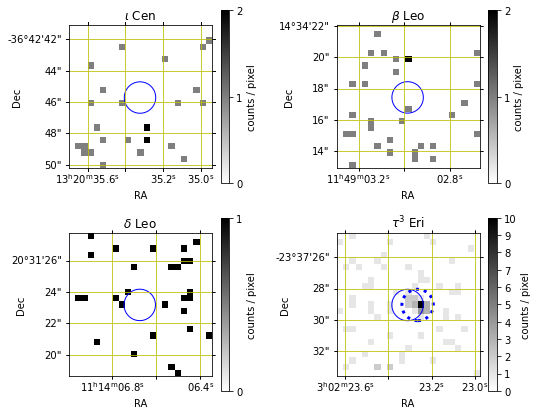

In [130]:
fig = plt.figure(figsize=(8, 7))
for i, target in enumerate(targets):
    obsid = target['OBSID']
    coord = target['coord_at_obs']
    hdu = fits.open(f'{obsid}_imcenter.fits')[0]
    wcs = WCS(hdu.header)
    ax = fig.add_subplot(2, 2, i+1, projection=wcs)
    im = ax.imshow(hdu.data, origin='lower', cmap=plt.get_cmap('binary'))
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('counts / pixel')
    # Since counts are integer values, we want to label only the integers
    cbar.ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.grid(color='y', ls='solid')
    r = SphericalCircle((coord.ra, coord.dec), 1 * u.arcsec,
                         edgecolor='b', facecolor='none',
                         transform=ax.get_transform('fk5'))
    ax.add_patch(r)
    ax.coords['ra'].set_axislabel('RA')
    ax.coords['ra'].set_ticklabel(exclude_overlapping=True)
    # minpad moved the "Dec". A negative value moves id in a little bit.
    ax.coords['dec'].set_axislabel('Dec', minpad=-1)
    ax.set_title(target['target'])
    if target['OBSID'] == '18933':
        # We see that the coordinates are slightly off in wa way that's consistent with another
        # source in the field and with the Chandra coordinate uncertainty. So, we draw a new 
        # circle around the source that we actually see.
        coord = target['coord_used']
        r = SphericalCircle((coord.ra, coord.dec), 1 * u.arcsec,
                             edgecolor='b', facecolor='none', linestyle=':',
                             transform=ax.get_transform('fk5'), linewidth=3)
        ax.add_patch(r)

fig.subplots_adjust(wspace=.5)
fig.savefig('chandra.pdf', bbox_inches='tight')

Now, we need to measure background rates. So, we need a larger, source-free region we can use. For this purpose, we just take a big area centered on our source and subtract all locations where we found sources  with `wavdetect` above.

In [159]:
for target in targets:
    obsid = target['OBSID']
    print('Extracting src and bkg for obsid: ', obsid)
    coord = target['coord_used']
    fileevt2 = glob(f'{obsid}/repro/*evt2*')[0]    
    # Background region: Annulus around the source, removing any detected point sources
    bkgfilter = f"annulus({coord.ra.deg}d,{coord.dec.deg}d,.1',2.5')"
    with open(f'{obsid}/src.reg') as f:
        for line in f:
            bkgfilter += f'-{line}'.replace('\n', '')
    rt.dmextract.punlearn()
    rt.dmextract(infile=f"{fileevt2}[bin sky=circle({coord.ra.deg}d,{coord.dec.deg}d,1.5'')]",
                 bkg=f'{fileevt2}[bin sky={bkgfilter}]',
                 outfile=f'{obsid}_dmextract.fits', clobber=True)

Working on  18930
Working on  18931
Working on  18932
Working on  18933


Now, we want count numbers, rates, and confidence limits. CIAO offers very advanced and flexible tools for that ([srcfulx](https://cxc.cfa.harvard.edu/ciao/ahelp/srcflux.html) and [aprates](https://cxc.cfa.harvard.edu/ciao/ahelp/aprates.html)). However, the fact that we are using the HRC, which has essentially no intrisic energy resolution, means that we do not benefit from the ability of the [srcfulx](https://cxc.cfa.harvard.edu/ciao/ahelp/srcflux.html) script to take into account specific spectral models. We can also easily make almost "perfect" source and background apertures, where "perfect" means that the entire source PSF is contained inside the source aperture and no part of the source is contained in the background aperture. Our sources are on-axis, where Chandra's PSF is very narrow, and they are weak (in fact most of them are undetected), so that we can, in good conscious, ignore the wings of the PSF.

For the background, we use an annulus with an inner radius of 6 arcsec, safely outside the PSF, and for the source aperture we use a circle with a radius of 1.5 arcsec, which, for soft sources like in this case, catches >90% of the flux. We can correct for this fact in the end, but there is considerable uncertainty on the exact factor, so we do not want to use it as part of the analysis. [aprates](https://cxc.cfa.harvard.edu/ciao/ahelp/aprates.html) can deal with source counts in the background, and considers the uncertainty in the background (see [Primini & Kashyap (2014)](https://ui.adsabs.harvard.edu/abs/2014ApJ...796...24P/abstract)), but at the cost of long run-times if the background region is large. Since our background seem homogenoues, we take the simpler approach by [Kraft, Burrows, Nousek (1991)](https://ui.adsabs.harvard.edu/abs/1991ApJ...374..344K/abstract) which assumes that the background is well known (which we achieve by measurung it from a very large area) as implemented in astropy.

In [156]:
Table.read(f'18933_dmextract.fits')['COUNTS', 'AREA', 'BG_COUNTS', 'BG_AREA']

COUNTS,AREA,BG_COUNTS,BG_AREA
ct,pix2,ct,pix2
float64,float64,float64,float64
33.0,180.85022448540298,47471.0,4061002.0625


In [161]:
targets['src'] = 0
targets['src'].unit = u.count
targets['bkg'] = 0.
targets['bkg'].unit = u.count

for target in targets:
    obsid = target['OBSID']
    tab = Table.read(f'{obsid}_dmextract.fits')
    target['src'] = int(tab['COUNTS'][0])
    target['bkg'] = tab['BG_COUNTS'][0]/tab['BG_AREA'][0] * tab['AREA'][0]

In [162]:
targets

target,DATE-OBS,OBSID,RA (pointing),Dec (pointing),exp. time,name,obs. date,MAIN_ID,RA,DEC,RA_PREC,DEC_PREC,COO_ERR_MAJA,COO_ERR_MINA,COO_ERR_ANGLE,COO_QUAL,COO_WAVELENGTH,COO_BIBCODE,Distance_distance,Distance_Q,Distance_unit,Distance_merr,Distance_perr,Distance_method,Distance_bibcode,PMRA,PMDEC,PM_ERR_MAJA,PM_ERR_MINA,PM_ERR_ANGLE,PM_BIBCODE,SP_TYPE,SP_QUAL,SP_BIBCODE,FLUX_U,FLUX_BIBCODE_U,FLUX_B,FLUX_BIBCODE_B,FLUX_V,FLUX_BIBCODE_V,FLUX_R,FLUX_BIBCODE_R,coord,coord_at_obs,coord_used,src,bkg
,,,deg,deg,ks,,,,"""h:m:s""","""d:m:s""",,,mas,mas,deg,,,,,,,,,,,mas / yr,mas / yr,mas / yr,mas / yr,deg,,,,,mag,,mag,,mag,,mag,,"deg,deg,pc","deg,deg,pc","deg,deg,pc",ct,ct
str12,str19,str5,float64,float64,float64,str9,str10,object,str13,str13,int16,int16,float32,float32,int16,str1,str1,object,float64,str1,str4,float64,float64,str8,str19,float64,float64,float32,float32,int16,object,object,str1,object,float32,object,float32,object,float32,object,float32,object,object,object,object,int64,float64
$\iota$ Cen,2017-03-31T13:22:55,18930,200.1525,-36.7119,9.7,iota Cen,2017-03-31,* iot Cen,13 20 35.8128,-36 42 44.296,14,14,0.867,0.915,90,A,O,2018yCat.1345....0G,17.8390,,pc,-0.3547,0.3547,paral,2018yCat.1345....0G,-339.615,-82.181,1.588,1.593,90,2018yCat.1345....0G,kA1.5hA3mA3Va,C,2006AJ....132..161G,2.77,2002yCat.2237....0D,2.76,2002yCat.2237....0D,2.73,2002yCat.2237....0D,2.68,2002yCat.2237....0D,"200.14921999999999,-36.71230444444445,17.839","200.1471905017947,-36.7126981171705,17.838999981929057","200.1471905017947,-36.7126981171705,17.838999981929057",1,2.4984975961538467
$\beta$ Leo,2017-04-05T16:12:29,18931,177.2635,14.5719,10.1,beta Leo,2017-04-05,* bet Leo,11 49 03.5783,+14 34 19.409,9,9,7.630,3.860,90,A,O,2007A&A...474..653V,11.0910,,pc,-0.1090,0.1090,ST-L,2009ApJ...694.1085V,-497.680,-114.670,0.870,0.440,0,2007A&A...474..653V,A3Va,C,2009ApJ...694.1085V,2.3,2002yCat.2237....0D,2.22,2002yCat.2237....0D,2.13,2009ApJ...694.1085V,2.08,2002yCat.2237....0D,"177.26490958333332,14.572058055555555,11.091","177.26244419834208,14.571508267084944,11.090999988901109","177.26244419834208,14.571508267084944,11.090999988901109",1,2.226873440198079
$\delta$ Leo,2017-02-05T05:48:56,18932,168.5285,20.5240,10.1,delta Leo,2017-02-05,* del Leo,11 14 06.5014,+20 31 25.385,9,9,2.640,1.840,90,A,O,2007A&A...474..653V,17.6930,,pc,-0.2600,0.2600,ST-L,2009ApJ...694.1085V,143.420,-129.880,0.300,0.210,0,2007A&A...474..653V,A5IV(n),C,2003AJ....126.2048G,2.79,2002yCat.2237....0D,2.68,2002yCat.2237....0D,2.53,2009ApJ...694.1085V,2.44,2002yCat.2237....0D,"168.52708916666663,20.523718055555555,17.693","168.52781645974414,20.523101225964965,17.692999994595084","168.52781645974414,20.523101225964965,17.692999994595084",3,2.2467980201729154
$\tau^3$ Eri,2017-06-09T12:15:45,18933,45.5957,-23.6223,19.9,tau03 Eri,2017-06-09,* tau03 Eri,03 02 23.4993,-23 37 28.093,11,11,0.130,0.130,90,A,O,2007A&A...474..653V,25.9169,,pc,-0.2595,0.2595,paral,2018yCat.1345....0G,-147.250,-55.280,0.170,0.170,90,2007A&A...474..653V,A3IV-V,C,2006AJ....132..161G,4.33,2002yCat.2237....0D,4.25,2002yCat.2237....0D,4.09,2002yCat.2237....0D,3.96,2002yCat.2237....0D,"45.59791375,-23.624470277777778,25.9169","45.597135266916126,-23.624738036858812,25.916899991184867","45.59694082247168,-23.624738036858812,25.916899991184867",34,4.756601195331153


In [203]:
targets['net. counts'] = poisson_conf_interval(targets['src'], background=targets['bkg'],
                         confidence_level=0.90, interval='kraft-burrows-nousek').T
# Units get lost when poisson_conf_interval calls scipy or mpmath underneath
targets['net. counts'].unit = targets['src'].unit
targets['net. counts'].format = '4.1f'
targets['net. rate'] = targets['net. counts'] / targets['exp. time'][:, np.newaxis]
# Units are not automativally handled for astropy Table, we would have to use a QTable
targets['net. rate'].unit = targets['net. counts'].unit / targets['exp. time'].unit
targets['net. rate'].format = '4.1f'

In [292]:
conversion_factor = 1e-14 * u.erg / u.s / u.cm**2/ (u.count / u.ks)

In [299]:
targets['net. flux'] = targets['net. rate'] * conversion_factor 
lxlim997 = 5.7 * u.ct /  targets['exp. time'] * conversion_factor * 4 * np.pi * (targets['Distance_distance'] * u.pc)**2
lxlim997 = lxlim997.to(u.erg/u.s)
targets['lxlim'] = lxlim997
targets['upper lim $\log(L_X/L_\mathrm{bol})$'] = np.log10(lxlim997 / (np.array([20.1, 13.0, 22.1, 12.0]) * u.L_sun))

In [300]:
lx = targets['net. rate'] * conversion_factor * 4 * np.pi * (targets['Distance_distance'][:, np.newaxis] * u.pc)**2
lx = lx.to(u.erg/u.s)
targets['$L_X$'] = lx
targets['$\log(L_X)$'] = np.log10(lx.value)

/Users/hamogu/anaconda3/envs/ciao/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


In [302]:
# From Simon et al (2002)
targets['$L_\mathrm{bol}$'] = [20.1, 13.0, 22.1, 12.0] * u.L_sun

In [303]:
targets['$\log(L_X/L_\mathrm{bol})$'] = np.log10((lx / (np.array([20.1, 13.0, 22.1, 12.0]) * u.L_sun)[:, np.newaxis]).decompose())

In [304]:
targets

target,DATE-OBS,OBSID,RA (pointing),Dec (pointing),exp. time,name,obs. date,MAIN_ID,RA,DEC,RA_PREC,DEC_PREC,COO_ERR_MAJA,COO_ERR_MINA,COO_ERR_ANGLE,COO_QUAL,COO_WAVELENGTH,COO_BIBCODE,Distance_distance,Distance_Q,Distance_unit,Distance_merr,Distance_perr,Distance_method,Distance_bibcode,PMRA,PMDEC,PM_ERR_MAJA,PM_ERR_MINA,PM_ERR_ANGLE,PM_BIBCODE,SP_TYPE,SP_QUAL,SP_BIBCODE,FLUX_U,FLUX_BIBCODE_U,FLUX_B,FLUX_BIBCODE_B,FLUX_V,FLUX_BIBCODE_V,FLUX_R,FLUX_BIBCODE_R,coord,coord_at_obs,coord_used,src,bkg,net. counts [2],net. rate [2],$L_X$ [2],net. flux [2],$\log(L_X)$ [2],$L_\mathrm{bol},$L_\mathrm{bol}$,$\log(L_X/L_\mathrm{bol})$ [2],lxlim,upper lim $\log(L_X/L_\mathrm{bol})$
,,,deg,deg,ks,,,,"""h:m:s""","""d:m:s""",,,mas,mas,deg,,,,,,,,,,,mas / yr,mas / yr,mas / yr,mas / yr,deg,,,,,mag,,mag,,mag,,mag,,"deg,deg,pc","deg,deg,pc","deg,deg,pc",ct,ct,ct,ct / ks,erg / s,erg / (cm2 s),,solLum,solLum,,erg / s,
str12,str19,str5,float64,float64,float64,str9,str10,object,str13,str13,int16,int16,float32,float32,int16,str1,str1,object,float64,str1,str4,float64,float64,str8,str19,float64,float64,float32,float32,int16,object,object,str1,object,float32,object,float32,object,float32,object,float32,object,object,object,object,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
$\iota$ Cen,2017-03-31T13:22:55,18930,200.1525,-36.7119,9.7,iota Cen,2017-03-31,* iot Cen,13 20 35.8128,-36 42 44.296,14,14,0.867,0.915,90,A,O,2018yCat.1345....0G,17.8390,,pc,-0.3547,0.3547,paral,2018yCat.1345....0G,-339.615,-82.181,1.588,1.593,90,2018yCat.1345....0G,kA1.5hA3mA3Va,C,2006AJ....132..161G,2.77,2002yCat.2237....0D,2.76,2002yCat.2237....0D,2.73,2002yCat.2237....0D,2.68,2002yCat.2237....0D,"200.14921999999999,-36.71230444444445,17.839","200.1471905017947,-36.7126981171705,17.838999981929057","200.1471905017947,-36.7126981171705,17.838999981929057",1,2.4984975961538467,0.0 .. 2.9,0.0 .. 0.3,0.0 .. 1.1448994320155717e+26,0.0 .. 3.006875001458325e-15,-inf .. 26.058767339917047,20.1,20.1,-inf .. -8.827400646608247,2.244527462558968e+26,-8.535043063014019
$\beta$ Leo,2017-04-05T16:12:29,18931,177.2635,14.5719,10.1,beta Leo,2017-04-05,* bet Leo,11 49 03.5783,+14 34 19.409,9,9,7.630,3.860,90,A,O,2007A&A...474..653V,11.0910,,pc,-0.1090,0.1090,ST-L,2009ApJ...694.1085V,-497.680,-114.670,0.870,0.440,0,2007A&A...474..653V,A3Va,C,2009ApJ...694.1085V,2.3,2002yCat.2237....0D,2.22,2002yCat.2237....0D,2.13,2009ApJ...694.1085V,2.08,2002yCat.2237....0D,"177.26490958333332,14.572058055555555,11.091","177.26244419834208,14.571508267084944,11.090999988901109","177.26244419834208,14.571508267084944,11.090999988901109",1,2.226873440198079,0.0 .. 3.0,0.0 .. 0.3,0.0 .. 4.3225998681176405e+25,0.0 .. 2.936923746921443e-15,-inf .. 25.63574503587803,13.0,13.0,-inf .. -9.061170245533612,8.345784037724602e+25,-8.775448139046736
$\delta$ Leo,2017-02-05T05:48:56,18932,168.5285,20.5240,10.1,delta Leo,2017-02-05,* del Leo,11 14 06.5014,+20 31 25.385,9,9,2.640,1.840,90,A,O,2007A&A...474..653V,17.6930,,pc,-0.2600,0.2600,ST-L,2009ApJ...694.1085V,143.420,-129.880,0.300,0.210,0,2007A&A...474..653V,A5IV(n),C,2003AJ....126.2048G,2.79,2002yCat.2237....0D,2.68,2002yCat.2237....0D,2.53,2009ApJ...694.1085V,2.44,2002yCat.2237....0D,"168.52708916666663,20.523718055555555,17.693","168.52781645974414,20.523101225964965,17.692999994595084","168.52781645974414,20.523101225964965,17.692999994595084",3,2.2467980201729154,0.0 .. 4.8,0.0 .. 0.5,0.0 .. 1.775426584276924e+26,0.0 .. 4.740114244388723e-15,-inf .. 26.249302718483523,22.1,22.1,-inf .. -8.678061484306395,2.1225557157481705e+26,-8.6005051037682
$\tau^3$ Eri,2017-06-09T12:15:45,18933,45.5957,-23.6223,19.9,tau03 Eri,2017-06-09,* tau03 Eri,03 02 23.4993,-23 37 28.093,11,11,0.130,0.130,90,A,O,2007A&A...474..653V,25.9169,,pc,-0.2595,0.2595,paral,2018yCat.1345....0G,-147.250,-55.280,0.170,0.170,90,2007A&A...474..653V,A3IV-V,C,2006AJ....132..161G,4.33,2002yCat.2237....0D,4.25,2002yCat.2237....0D,4.09,2002yCat.2237....0D,3.96,2002y

Now, the net counts and net rate are columns with vectors values (lower, upper limit). For output to LaTeX, I want to reformat that a little.

In [306]:
# Some formatting for columns that we'll put out into LaTeX later
for col in ['net. counts', 'net. rate', '$\log(L_X)$', '$\log(L_X/L_\mathrm{bol})$',
            'upper lim $\log(L_X/L_\mathrm{bol})$']:
    targets[col].format='4.1f'
for col in ['net. flux', 'lxlim']:
    targets[col].format='7.2g'

In [307]:
targets['target', 'net. counts', 'net. rate', 'net. flux', '$\log(L_X/L_\mathrm{bol})$', 
        'lxlim', 'upper lim $\log(L_X/L_\mathrm{bol})$'].write(sys.stdout,
            format='ascii.latex', latexdict=ascii.latexdicts['AA'],
            caption=r'Limits and fluxes. Ranges given are 90\% confidence regions.\label{tab:detections}')

\begin{table}
\caption{Limits and fluxes. Ranges given are 90\% confidence regions.\label{tab:detections}}
\begin{tabular}{ccccccc}
\hline \hline
target & net. counts & net. rate & net. flux & $\log(L_X/L_\mathrm{bol})$ & lxlim & upper lim $\log(L_X/L_\mathrm{bol})$ \\
 & $\mathrm{ct}$ & $\mathrm{ct\,ks^{-1}}$ & $\mathrm{erg\,s^{-1}\,cm^{-2}}$ & $\mathrm{}$ & $\mathrm{erg\,s^{-1}}$ & $\mathrm{}$ \\
\hline
$\iota$ Cen & 0.0 ..  2.9 & 0.0 ..  0.3 & 0 ..   3e-15 & -inf .. -8.8 & 2.2e+26 & -8.5 \\
$\beta$ Leo & 0.0 ..  3.0 & 0.0 ..  0.3 & 0 .. 2.9e-15 & -inf .. -9.1 & 8.3e+25 & -8.8 \\
$\delta$ Leo & 0.0 ..  4.8 & 0.0 ..  0.5 & 0 .. 4.7e-15 & -inf .. -8.7 & 2.1e+26 & -8.6 \\
$\tau^3$ Eri & 20.5 .. 39.8 & 1.0 ..  2.0 & 1e-14 ..   2e-14 & -7.7 .. -7.5 & 2.3e+26 & -8.3 \\
\hline
\end{tabular}
\end{table}
